<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace_frozen_mlp_attn.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Frozen-MLP causal tracing

This notebook executes causal traces with all the MLP modules for a token disabled (we also do Attn modules separately), by freezing them at the corrupted state.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, re
import torch, numpy
import importlib, copy
import transformers
from collections import defaultdict
from util import nethook
from matplotlib import pyplot as plt
from experiments.causal_trace import (
    ModelAndTokenizer,
    make_inputs,
    predict_from_input,
    decode_tokens,
    layername,
    find_token_range,
    trace_with_patch,
    plot_trace_heatmap,
    collect_embedding_std,
)
from util.globals import DATA_DIR
from dsets import KnownsDataset

# for testing
import sys

Load model and compute its corresponding noise level.

In [5]:
model_name = "gpt2-xl"  # "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

/home/smille20/miniconda/envs/rome/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
# noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])

noise_level = 0.1
print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements
Using noise level 0.1


## Tracing a single location

The strategy here is to use three interventions, rather than two:

1. As before, corrupt a subset of the input.
2. As before, restore a subset of the internal hidden states to see
   which ones restore the output.
3. But now, while doing so, freeze a set of MLP modules when processing
   the specific subject token, so that they are stuck in the corrupted
   state.  This reveals effect of the hidden states on everything
   except for those particular MLP executions.
   
This three-way intervention is implemented in `trace_with_repatch`

In [7]:
# performs an individual corrupted-with-restoration run on the modified computation graph
def trace_with_repatch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) tuples to restore
    states_to_unpatch,  # A list of (token index, layername) tuples to restore to their corrupted counterparts
    answers_t,  # index of the correct answer in the vocabulary to collect probs of
    tokens_to_mix,  # Range of tokens to corrupt [begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise

    # defaultdict that stores the hidden states to restore to their clean states
    # where KEY = named layer (module) and VALUE = list of associated token indicies
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)

    # defaultdict that stores the MLP module outputs to restore to their corrupted states
    # where KEY = named layer (module) and VALUE = list of associated token indicies
    unpatch_spec = defaultdict(list)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # inputs: x = output of a layer,
    #         layer = named layer (module)
    # output: modified output
    # Define the model-patching rule. (essentially our named layer output editor)
    def patch_rep(x, layer):
        if layer == "transformer.wte":
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x

        # for each layer from the first pass simply return the outputs of the corrupted run
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)

        # check if the named layer (module) currently being processed is in patch_spec.
        # if the named layer is in patch_spec then restore its clean state. otherwise
        # do nothing
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]

        # check if the named layer (module) currently being processed is in unpatch_spec.
        # if the named layer is in unpatch_spec then restore it to its corrupted state. otherwise
        # do nothing
        # t is the named layer's associated token index
        for t in unpatch_spec.get(layer, []):
            # since first_pass_trace is a TraceDict, first lookup the Trace object associated with
            # the named layer. Then get its stored output from the first forward pass, and modify
            # the output tensor [# of prompt copies, # of tokens, embedding size] for all non-clean samples
            # at token index t to be their baseline corrupted states. 
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    # note: if you want to run a corrupted-with-restoration run on a modified computation graph
    #       where the mlp/attn modules of a layer are frozen, two forward passes through the network are needed.
    #       the first_pass (first forward pass) is used to retain the outputs of the named layers
    #       (modules) from the corrupted run for use in the second forward pass.
    for first_pass in [True, False] if states_to_unpatch else [False]:
        # input: model, 
        #        desired layers to retain the outputs of (list of named layers aka string
        #        representations of code to access those layers from the model),
        #        edit_output is a pointer to a function that takes two arguments:
        #        an output (hidden state/MLP layer output/Attention layer output)
        #        and a named layer and returns the modified output
        # output: a TraceDict object, which is an ordered dictionary data structure.
        #         whose KEYS are the passed named layers (modules) and the VALUES are their
        #         associated Trace objects
        # when a named layer's associated Trace object is created, the retain_hook function
        # is registered as a forward hook for the named layer (module in the network). 
        # essentially what registering a forward hook for the named layer (module) does is
        # call the retain_hook function after the output of the named layer has been computed
        # by calling the layer module's forward function.
        # the retain_hook function allows for the retaining of the input to the layer module,
        # modifying of the output of the layer module (through the patch_rep function), 
        # and/or retaining of the output of the layer module
        with torch.no_grad(), nethook.TraceDict(
            model,
            ["transformer.wte"] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            # perform forward pass
            outputs_exp = model(**inp)

            if first_pass:
                first_pass_trace = td

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # returns the probability of predicting the answer predicted in the clean run
    return probs

## Tracing all locations

Now we just need to repeat it over all locations, and draw the heatmaps.

In [8]:
# note: this function operates very similarly with the calculate_hidden_flow function in causal_trace.ipynb.
#       for commentary on shared behaviors, reference the comments in that function.
def calculate_hidden_flow_3(
    mt, # ModelAndTokenizer object that stores the model and its associated tokenizer
    prompt, # natural language description of the subject and relation
    subject, # subject portion of the fact
    token_range=None, # flag that specifies whether causal traces should be run over all tokens or just 'last_subject' token
    samples=10, # specifies the number of "runs" to perform for the corrupted run and each corrupted-with-restoration run
    noise=0.1, # Level of noise to be used to scale samples from the standard normal distribution used for subject corruption
    window=10, # note: this arg doesn't get used in this context
    extra_token=0, # allows for additional token indices to be considered as part of the subject's index range (e_range) 
    disable_mlp=False, # set all layers' mlp component outputs to their corrupted states for a restored state's associated token 
    disable_attn=False, # set all layers' attn component outputs to their corrupted states for a restored state's associated token
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    # inp is a dictionary with keys: input_ids and attention_mask, their associated values are
    # both tensors with shape [11, # of tokens in prompt]
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))

    # clean run
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    # e_range is a tuple (index of first subject token, index of first token following the last subject token)
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

    # only perform corrupted-with-restoration runs over the token/layer combinations that contain the last subject token
    if token_range == "last_subject":
        token_range = [e_range[1] - 1]
    e_range = (e_range[0], e_range[1] + extra_token)

    # corrupted run
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()

    # corrupted-with-restoration runs (with frozen MLP layers/attn layers)
    differences = trace_important_states_3(
        mt.model,
        mt.num_layers,
        inp,
        e_range,
        answer_t,
        noise=noise,
        disable_mlp=disable_mlp,
        disable_attn=disable_attn,
        token_range=token_range,
    )

    differences = differences.detach().cpu()
    return dict(
        scores=differences, # probs of correct answer for all corrupted-with-restoration runs
        low_score=low_score, # prob of predicting the correct subject in the corrupted run
        high_score=base_score, # prob of predicting the correct subject in the clean run
        input_ids=inp["input_ids"][0], # input_ids of prompt
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]), # actual tokens of prompt
        subject_range=e_range, # tuple(starting index of subject, index of first token after subject)
        answer=answer, # predicted token in clean run
        window=window, # passed in window
        kind="", # always "" since only restoring hidden states
    )


# returns the probabilities of predicting the correct answer as the next token for all of the 
# corrupted-with-restoration runs when restoring hidden states (at a token/layer) and (potentially)
# corrupting mlp/attn component outputs for all layers of the hidden states' associated token 
# in the form of a 2-D tensor (tensor.shape = [# of tokens, # of layers])
# performs all the corrupted-with-restoration runs on the modified computation graph
def trace_important_states_3(
    model, # model to be used
    num_layers, # model's number of layers
    inp, # dictionary containing the input_ids and attention_masks of the copies of the prompt
    e_range, # tuple(starting index of subject, index of first token after subject)
    answer_t, # index of the correct answer in the vocabulary (aka integer representation of the correct token)
    noise=0.1, # noise level to be used for subject corruption
    disable_mlp=False, # set all layers' mlp component outputs to their corrupted states for a restored state's associated token
    disable_attn=False, # set all layers' attn component outputs to their corrupted states for a restored state's associated token
    token_range=None, # list containing the index of the last subject token
):
    ntoks = inp["input_ids"].shape[1]

    # stores probability of predicting the correct object for all corrupted-with-restoration runs
    # with (potentially) frozen (from corrupted run) mlp outputs and/or attn outputs
    table = []

    # stores tuples of (token index, named layer (module)) for all layers of the model. depending
    # on if an element was appended due to the 'disable_mlp' flag or 'disable_attn' flag being set
    # to true, the named layer (module) will reference the layer's 'mlp' or 'attn' component respectively  
    # ex. 'transformer.h.{layer_num}.mlp' or 'transformer.h.{layer_num}.attn'
    #
    # essentially stores the layer module components that should have their outputs restored to their corrupted state
    # for each token
    zero_mlps = []

    if token_range is None:
        token_range = range(ntoks)

    # iterate over the passed in list of tokens or over all prompt tokens
    for tnum in token_range:
        # clear out zero_mlps for each token processed
        zero_mlps = []

        if disable_mlp:
            zero_mlps = [
                (tnum, layername(model, L, "mlp")) for L in range(0, num_layers)
            ]

        if disable_attn:
            zero_mlps += [
                (tnum, layername(model, L, "attn")) for L in range(0, num_layers)
            ]

        # (list of single value tensors)
        # stores the probabilities of predicting the correct answer as the next token for
        # corrupted-with-restoration runs that restore hidden states directly associated with
        # the token at index tnum of the prompt and (based on the values passed in for disable_mlp
        # and disable_attn) re-corrupt mlp/attn component outputs at all layers of the model
        row = []

        # iterate over all of the model's layers
        for layer in range(0, num_layers):
            r = trace_with_repatch(
                model,
                inp,
                [(tnum, layername(model, layer))], # hidden states to patch
                zero_mlps,  # states_to_unpatch
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)

        # converts a list of probs (single value tensors) into one tensor of shape [# of layers]
        table.append(torch.stack(row))
    return torch.stack(table)

Here is a causal trace with MLP disabled - it looks quite different from normal.

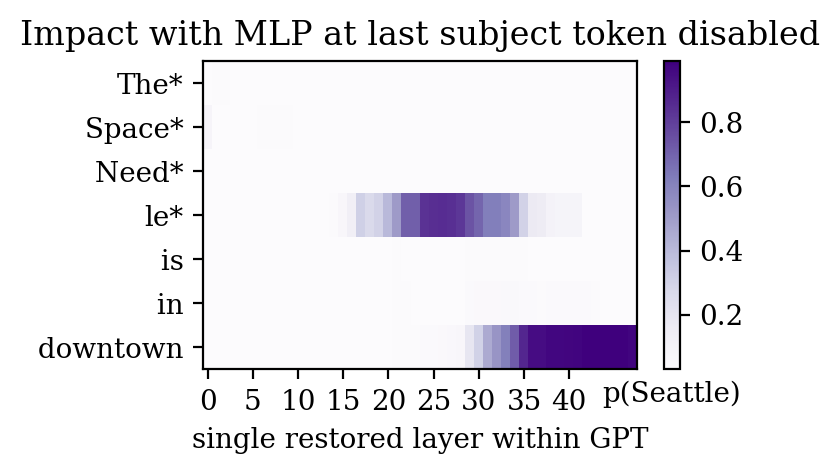

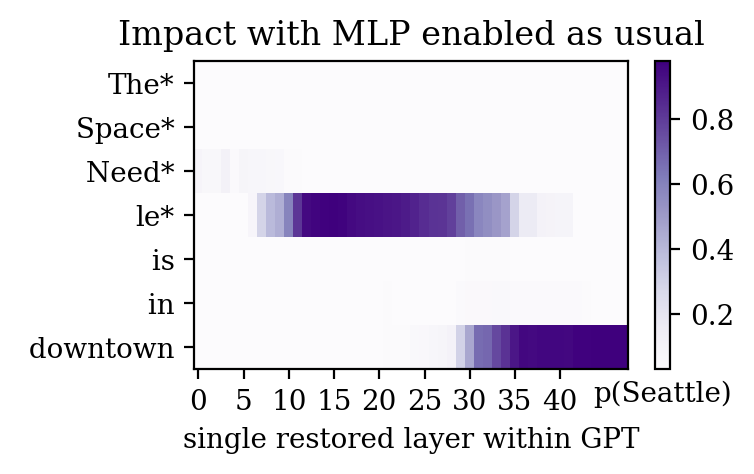

In [9]:
# prefix = "Megan Rapinoe plays the sport of"
# entity = "Megan Rapinoe"

prefix = "The Space Needle is in downtown"
entity = "The Space Needle"

no_mlp_r = calculate_hidden_flow_3(
    mt, prefix, entity, disable_mlp=True, noise=noise_level
)

# # for testing
# no_mlp_r = calculate_hidden_flow_3(
#     mt, prefix, entity, token_range = 'last_subject', disable_mlp=True, noise=noise_level
# )
# print(no_mlp_r['scores'].shape)

plot_trace_heatmap(no_mlp_r, title="Impact with MLP at last subject token disabled")
ordinary_r = calculate_hidden_flow_3(mt, prefix, entity, noise=noise_level)
plot_trace_heatmap(ordinary_r, title="Impact with MLP enabled as usual")

## Comparing the with-MLP/Attn and without-MLP/Attn traces

Plotting on a bar graph makes it easier to see the difference between the causal effects with and without MLP enabled.

In [10]:
def plot_last_subject(mt, prefix, entity, token_range="last_subject", savepdf=None):
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt, prefix, entity, token_range=token_range
    )
    plot_comparison(ordinary, no_attn, no_mlp, prefix, savepdf=savepdf)


def calculate_last_subject(mt, prefix, entity, cache=None, token_range="last_subject"):
    def load_from_cache(filename):
        try:
            dat = numpy.load(f"{cache}/{filename}")
            return {
                k: v
                if not isinstance(v, numpy.ndarray)
                else str(v)
                if v.dtype.type is numpy.str_
                else torch.from_numpy(v)
                for k, v in dat.items()
            }
        except FileNotFoundError as e:
            return None

    no_attn_r = load_from_cache("no_attn_r.npz")
    uncached_no_attn_r = no_attn_r is None
    no_mlp_r = load_from_cache("no_mlp_r.npz")
    uncached_no_mlp_r = no_mlp_r is None
    ordinary_r = load_from_cache("ordinary.npz")
    uncached_ordinary_r = ordinary_r is None
    if uncached_no_attn_r:
        no_attn_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_attn=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_no_mlp_r:
        no_mlp_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_mlp=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_ordinary_r:
        ordinary_r = calculate_hidden_flow_3(
            mt, prefix, entity, token_range=token_range, noise=noise_level
        )
    if cache is not None:
        os.makedirs(cache, exist_ok=True)
        for u, r, filename in [
            (uncached_no_attn_r, no_attn_r, "no_attn_r.npz"),
            (uncached_no_mlp_r, no_mlp_r, "no_mlp_r.npz"),
            (uncached_ordinary_r, ordinary_r, "ordinary.npz"),
        ]:
            if u:
                numpy.savez(
                    f"{cache}/{filename}",
                    **{
                        k: v.cpu().numpy() if torch.is_tensor(v) else v
                        for k, v in r.items()
                    },
                )
    if False:
        return (ordinary_r["scores"][0], no_attn_r["scores"][0], no_mlp_r["scores"][0])
    return (
        ordinary_r["scores"][0] - ordinary_r["low_score"],
        no_attn_r["scores"][0] - ordinary_r["low_score"],
        no_mlp_r["scores"][0] - ordinary_r["low_score"],
    )

    # return ordinary_r['scores'][0], no_attn_r['scores'][0]


def plot_comparison(ordinary, no_attn, no_mlp, title, savepdf=None):
    with plt.rc_context(rc={"font.family": "DeJavu serif", "font.serif" : ["Times New Roman"]}):
        import matplotlib.ticker as mtick

        fig, ax = plt.subplots(1, figsize=(6, 1.5), dpi=300)
        ax.bar(
            [i - 0.3 for i in range(len(ordinary))],
            ordinary,
            width=0.3,
            color="#7261ab",
            label="Impact of single state on P",
        )
        ax.bar(
            [i for i in range(len(no_attn))],
            no_attn,
            width=0.3,
            color="#f3201b",
            label="Impact with Attn severed",
        )
        ax.bar(
            [i + 0.3 for i in range(len(no_mlp))],
            no_mlp,
            width=0.3,
            color="#20b020",
            label="Impact with MLP severed",
        )
        ax.set_title(
            title
        )  #'Impact of individual hidden state at last subject token with MLP disabled')
        ax.set_ylabel("Indirect Effect")
        # ax.set_xlabel('Layer at which the single hidden state is restored')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(None, max(0.025, ordinary.max() * 1.05))
        ax.legend()
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


if False:  # Some representative cases.
    plot_last_subject(mt, "Megan Rapinoe plays the sport of", "Megan Rapinoe")
    plot_last_subject(mt, "The Big Bang Theory premires on", "The Big Bang Theory")
    plot_last_subject(mt, "Germaine Greer's domain of work is", "Germaine Greer")
    plot_last_subject(mt, "Brian de Palma works in the area of", "Brian de Palma")
    plot_last_subject(mt, "The headquarter of Zillow is in downtown", "Zillow")
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi",
    )
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi Electric",
    )
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame")
    plot_last_subject(
        mt, "Madame de Montesson died in the city of", "Madame de Montesson"
    )
    plot_last_subject(mt, "Edmund Neupert, performing on the", "Edmund Neupert")

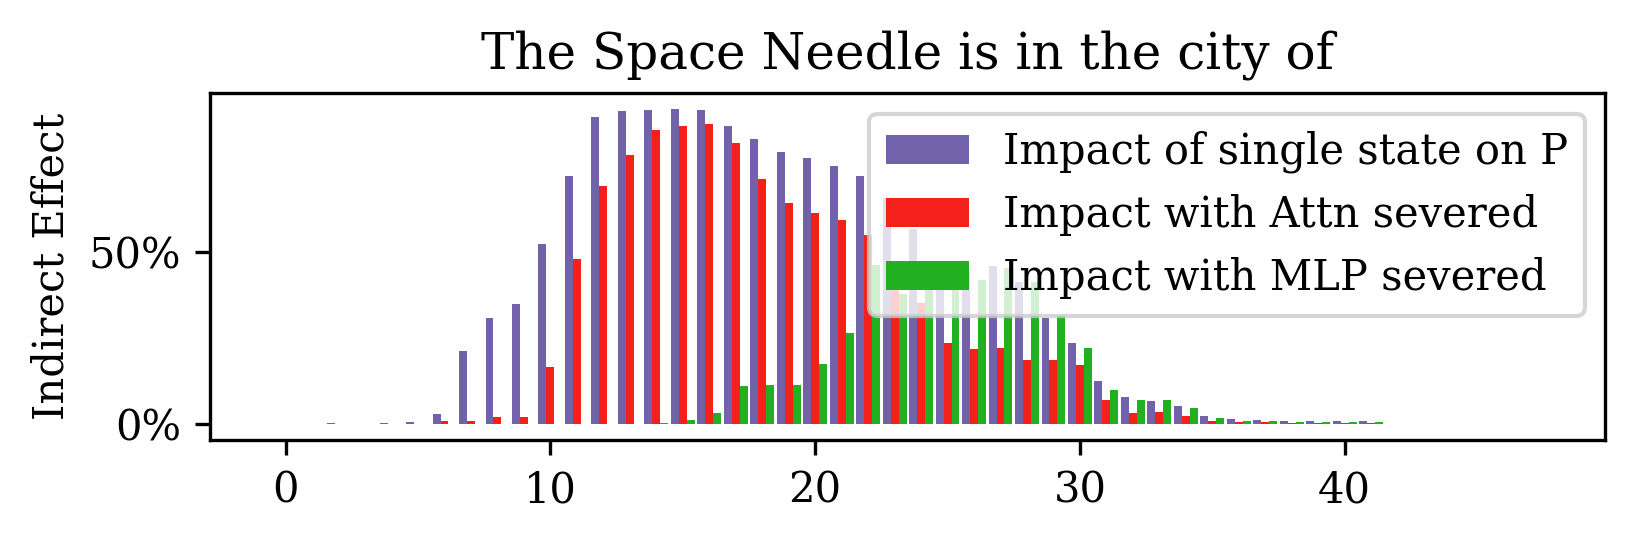

In [11]:
plot_last_subject(mt, "The Space Needle is in the city of", "The Space Needle")

## Average Indirect Effects

Now we average over hundreds of factual statements.

In [12]:
import tqdm

knowns = KnownsDataset(DATA_DIR)
all_ordinary = []
all_no_attn = []
all_no_mlp = []
for i, knowledge in enumerate(tqdm.tqdm(knowns[:1000])):
    # plot_all_flow(mt, knowledge['prompt'], knowledge['subject'])
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt,
        knowledge["prompt"],
        knowledge["subject"],
        cache=f"results/ct_disable_attn/case_{i}",
    )
    all_ordinary.append(ordinary)
    all_no_attn.append(no_attn)
    all_no_mlp.append(no_mlp)
title = "Causal effect of states at the early site with Attn or MLP modules severed"

avg_ordinary = torch.stack(all_ordinary).mean(dim=0)
avg_no_attn = torch.stack(all_no_attn).mean(dim=0)
avg_no_mlp = torch.stack(all_no_mlp).mean(dim=0)
import matplotlib.ticker as mtick

with plt.rc_context(rc={"font.family": "DeJavu serif", "font.serif" : ["Times New Roman"]}):
    fig, ax = plt.subplots(1, figsize=(6, 2.1), dpi=300)
    ax.bar(
        [i - 0.3 for i in range(48)],
        avg_ordinary,
        width=0.3,
        color="#7261ab",
        label="Effect of single state on P",
    )
    ax.bar(
        [i for i in range(48)],
        avg_no_attn,
        width=0.3,
        color="#f3201b",
        label="Effect with Attn severed",
    )
    ax.bar(
        [i + 0.3 for i in range(48)],
        avg_no_mlp,
        width=0.3,
        color="#20b020",
        label="Effect with MLP severed",
    )
    ax.set_title(
        title
    )  #'Impact of individual hidden state at last subject token with MLP disabled')
    ax.set_ylabel("Average Indirect Effect")
    ax.set_xlabel("Layer at which the single hidden state is restored")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(None, max(0.025, 0.105))

    ax.legend(frameon=False)
fig.savefig("causal-trace-no-attn-mlp.pdf", bbox_inches="tight")
print([d[20] - d[10] for d in [avg_ordinary, avg_no_attn, avg_no_mlp]])
print(avg_ordinary[15], avg_no_attn[15], avg_no_mlp[15])

Loaded dataset with 1209 elements


100%|██████████| 1000/1000 [00:08<00:00, 112.51it/s]


[tensor(-0.0179), tensor(-0.0126), tensor(0.0280)]
tensor(0.0866) tensor(0.0710) tensor(0.0325)


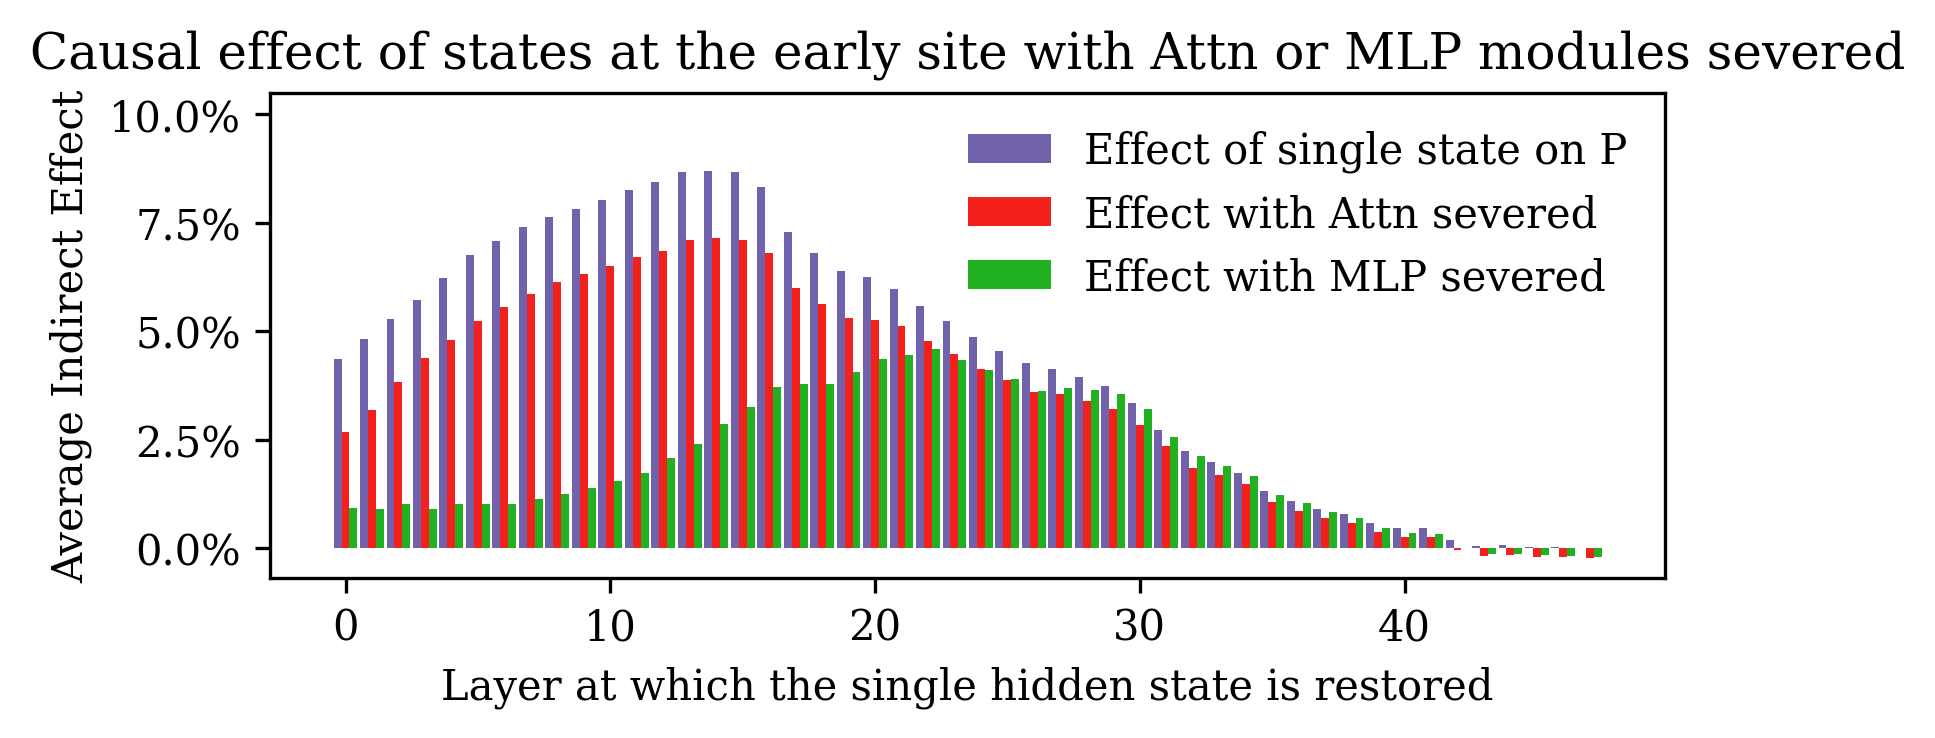

In [14]:
plt.show()